<a href="https://colab.research.google.com/github/kxk302/Covid_Clustering/blob/main/Covid_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!ls '/content/gdrive/MyDrive/Colab Notebooks/data/data.tsv'

'/content/gdrive/MyDrive/Colab Notebooks/data/data.tsv'





Data frame shape: (20000, 2)
Data frame columns: Index(['Sample', 'AF'], dtype='object')
Print data frame first 5 rows
       Sample      AF
0  ERR5549561  0.8071
1  ERR5549561  0.8216
2  ERR5549561  0.8732
3  ERR5549561  0.7786
4  ERR5549561  0.9595



Number of unique samples: 506
Sample minimum: ERR5549211
Sample maximum: ERR5673947



Number of unique af 3745
af minimum: 0.05
af maximum: 1.0



Rows with AF greater than 1.0
Empty DataFrame
Columns: [Sample, AF]
Index: []



Data frame shape: (20000, 2)
Data frame columns: Index(['Sample', 'AF'], dtype='object')
Print data frame first 5 rows
       Sample      AF
0  ERR5549561  0.8071
1  ERR5549561  0.8216
2  ERR5549561  0.8732
3  ERR5549561  0.7786
4  ERR5549561  0.9595



Data frame shape: (506, 1)
Data frame columns: Index(['AF'], dtype='object')
Print data frame first 5 rows
                                                           AF
Sample                                                       
ERR5549211  [0.8209, 0.9102, 

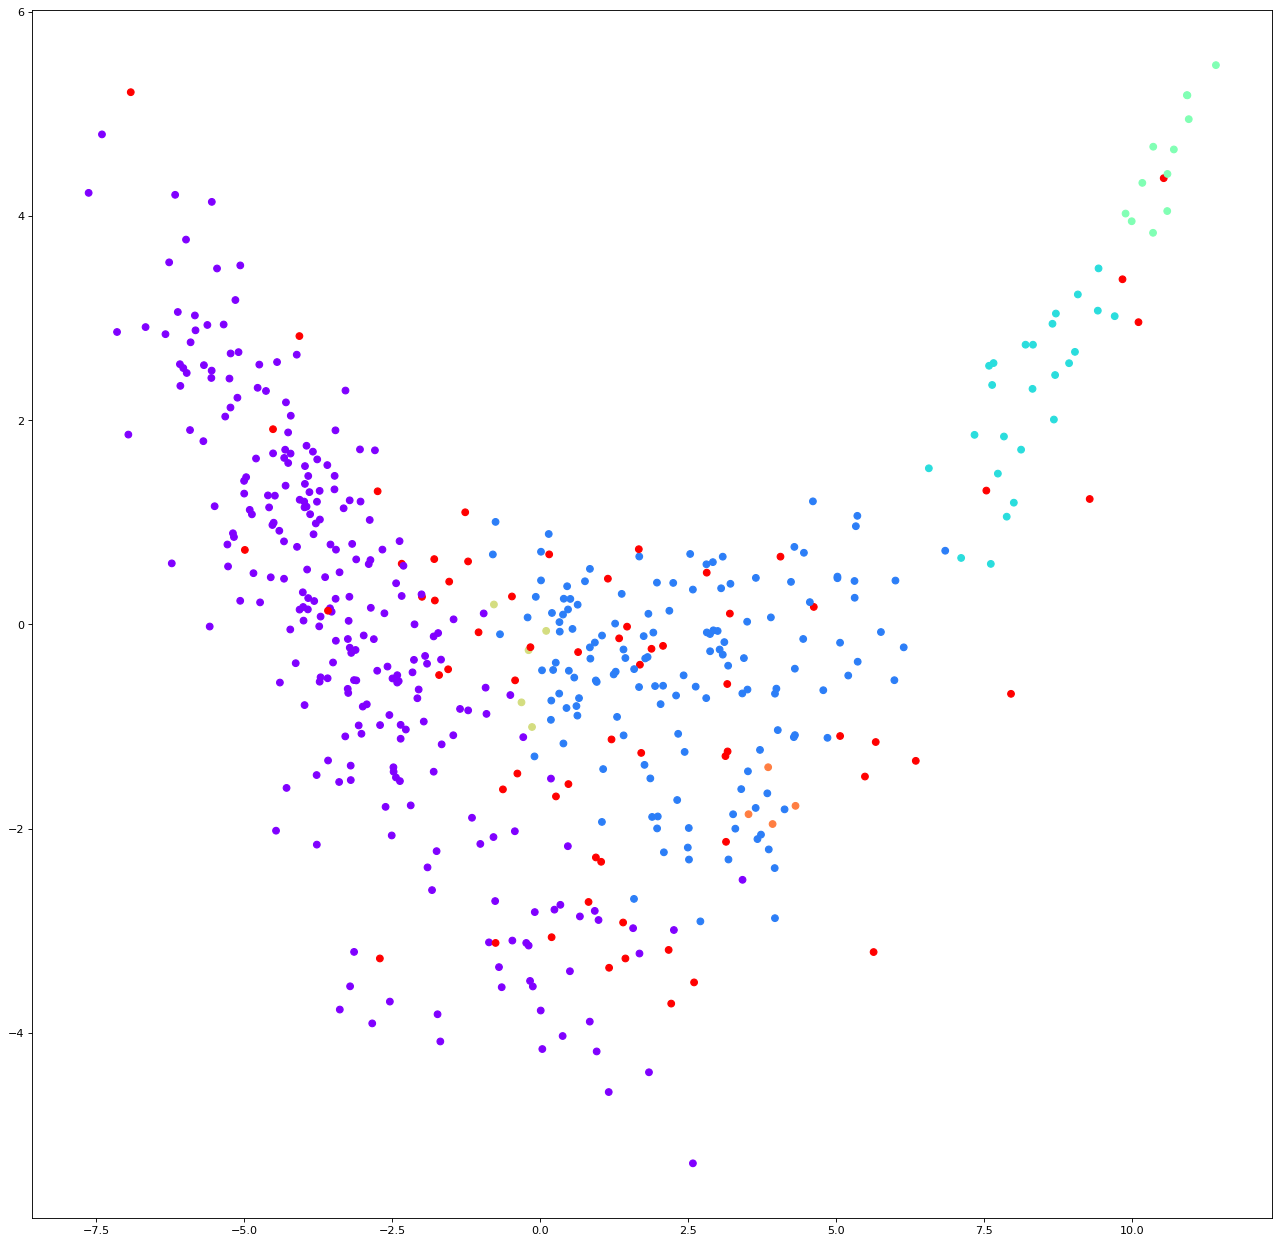

In [6]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt 
from matplotlib.pyplot import figure
from scipy.stats import entropy
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA 
from sklearn import metrics

pd.set_option('display.max_columns', None)

def df_stats(df):
  # Data frame stats
  print("\n\n")
  print("Data frame shape: {}".format(df.shape))
  print("Data frame columns: {}".format(df.columns))
  print("Print data frame first 5 rows")
  print(df.head(5))

def get_kde_values(row):
  return gaussian_kde(row['AF']).evaluate(ind)

def get_kl_div(x, y): 
  return entropy(x, y)

def get_label_to_color_dict(labels, colors):
  l2c_dict = {}
  idx = 0 
  for label in labels:
    l2c_dict[label] = colors[idx]
    idx += 1
  return l2c_dict  

# Read the input file
df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/data/data.tsv", sep="\t", names=["Sample", "Date_1", "Date_2", "UNK_1", "UNK_2", "POS", "REF", "ALT", "EFFECT", "CODON", "TRID", "AA", "AF"])

# Select only the needed columns
df = df[["Sample", "AF"]]

# DEBUG
# Select ONLY a subset of the dataset
# DEBUG
df = df.iloc[0:20000, :]

df_stats(df)

# Sample stats
print("\n\n")
print("Number of unique samples: {}".format(df["Sample"].nunique()))
print("Sample minimum: {}".format(df["Sample"].min()))
print("Sample maximum: {}".format(df["Sample"].max()))

# af stats
print("\n\n")
print("Number of unique af {}".format(df["AF"].nunique()))
print("af minimum: {}".format(df["AF"].min()))
print("af maximum: {}".format(df["AF"].max()))

# Clean up data by removing rows where af is greater than 1.0
print("\n\n")
print("Rows with AF greater than 1.0")
print(df[df.AF > 1.00])
df = df[df.AF <= 1.00]

df_stats(df)

# Pivot the data frame
df = pd.pivot_table(df, index="Sample", values="AF", aggfunc=list)

df_stats(df)

# Clean up data by removing rows where af list has only one element
print("\n\n")
print("Rows with AF list of size 1")
print(df[ df.AF.str.len() == 1 ])
df = df[ df.AF.str.len() > 1]

df_stats(df)

ind = np.linspace(0.00, 1.00, num=100)
df = df.apply(get_kde_values, axis=1)

print('\n\n')
print('KDE values')
print(df)

print('\n\n')
print("KL Divergence")
print(get_kl_div(df.iloc[0], df.iloc[1]))
print(get_kl_div(df.iloc[0], df.iloc[2]))
print(get_kl_div(df.iloc[0], df.iloc[3]))
print(get_kl_div(df.iloc[0], df.iloc[4]))
print(get_kl_div(df.iloc[0], df.iloc[5]))
print(get_kl_div(df.iloc[0], df.iloc[6]))
print(get_kl_div(df.iloc[0], df.iloc[7]))
print(get_kl_div(df.iloc[0], df.iloc[8]))
print(get_kl_div(df.iloc[0], df.iloc[9]))
print(get_kl_div(df.iloc[0], df.iloc[10]))

# Run DBSCAN clustering algorithm
print("type(df): {}".format(type(df)))
db = DBSCAN(eps=0.01, metric=get_kl_div).fit(df.values.tolist())

labels = db.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Labels length: {}".format(len(labels)))
print("Labels: {}".format(labels))
print("Unique labels: {}".format(set(labels)))

results_dict = {'KDE_vals': df, 'Labels': labels}
results = pd.DataFrame(results_dict)
df_stats(results)

# Bring the data to 2D using PCA, so it can be plotted
pca = PCA(n_components=2)
pca.fit(results.KDE_vals.tolist())
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
KDE_vals_2d = pca.transform(results.KDE_vals.tolist())
print(KDE_vals_2d)
print(type(KDE_vals_2d))

results['KDE_vals_2d'] = KDE_vals_2d.tolist()
df_stats(results)
results['x'] = results['KDE_vals_2d'].apply(lambda x: list(x)[0])
results['y'] = results['KDE_vals_2d'].apply(lambda x: list(x)[1])
print('Added x and y')
print(results.head())

# Plot 2D data.
# Color it based on the cluster it belongs to.
# Label it based on sample ID.

# Each cluster has a different color in the plot. +1 is to have a color for noise
colors = plt.cm.rainbow(np.linspace(0, 1, n_clusters_ + 1))
# Change colors from an ndarray to a tuple of tuples
print('Colors')
print(type(colors))
print(colors)
colors = [tuple(c) for c in colors]
print(colors)
colors = tuple(colors)
print(colors)

l2c_dict = get_label_to_color_dict(set(labels), colors)
print(l2c_dict)

results['colors'] = results['Labels'].map(l2c_dict)
df_stats(results)

plt.figure(figsize=(20, 20), dpi=80)
plt.scatter(results['x'].values.tolist(), results['y'].values.tolist(), color=tuple(results['colors'].values.tolist()), label=results.index)
plt.savefig('clustering.png')
plt.show()

# df.to_csv("./data/data_af.tsv", sep="\t", index=True, header=True)
